# Описание проекта
Нужно защитить данные клиентов страховой компании «Хоть потоп». Разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обосновать корректность его работы.
Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.
# Описание данных
Набор данных находится в файле /datasets/insurance.csv. Скачать датасет.
Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.
Целевой признак: количество страховых выплат клиенту за последние 5 лет.
# Инструменты 
pandas  
numpy  
sklearn  

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

## Загрузка данных

In [6]:
import pandas as pd
import numpy  as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#Это путь для загурзки в среде Практикума
file_location1 = "E:\Data\_Projects\datasets/insurance.csv"
file_location2 = "/datasets/insurance.csv"

if os.path.exists(file_location1):
    file_location = file_location1
elif os.path.exists(file_location2):
    file_location = file_location2
else:
    print('Something is wrong')
df=pd.read_csv(file_location)
df.head(3)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0


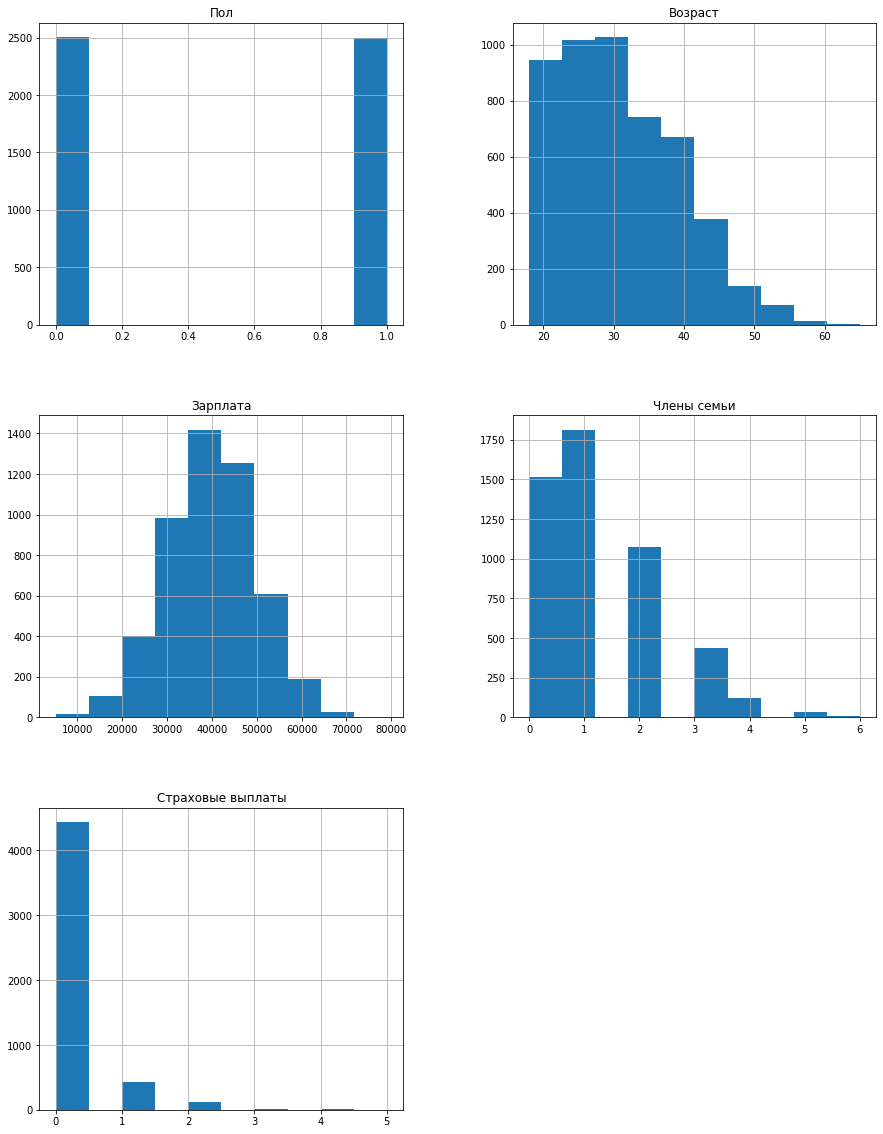

In [10]:
#Визуализируем данные в форме гистограмм
df.hist(figsize=(15, 20));
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [12]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [13]:
#проверим пропуски
df.isna().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

In [14]:
#проверим явные дубликаты
len(df)-len(df.drop_duplicates())

153

Явных дубликатов оказывается много. Они не принесут пользу нашей модели, удалим их.

In [15]:
df=df.drop_duplicates()

In [16]:
df.corr()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000000,0.001953,0.015456,-0.007315,0.011565
Возраст,0.001953,1.000000,-0.017386,-0.009064,0.654964
Зарплата,0.015456,-0.017386,1.000000,-0.031687,-0.013123
Члены семьи,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
Страховые выплаты,0.011565,0.654964,-0.013123,-0.039303,1.000000


**Вывод** Мы посмотрели на данные. Хорошо, что то в них нет пропусков, от дубликатов мы избавились. Диаграммы показывают, что все показатели в пределах разумных значений. Можно строить модель. Сильно коррелирующих показателей - только возраст, но это и логично. И не такое там значение, чтобы считать это проблемой с точки зрения мультиколлинеарности.

## Умножение матриц

In [17]:
#Сначала построим модель линейной регрессии для исходных данных, чтобы было с чем сравнивать.
X = df.drop('Страховые выплаты', axis=1).values
y=df['Страховые выплаты'].values
#Чтобы потом можно было проверить качество модели разделим датасет на тренировочный и тестовый
train_data, test_data, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=12345)
print(len(train_data), len(test_data))
model = LinearRegression()
model.fit(train_data, y_tr)
predictions = model.predict(test_data)
print(r2_score(y_te, predictions))

3877 970
0.4160549216151198


Качество модели оставляет желать лучшего, но наша цель защитить данные, а не подбирать оптимальную модель. 

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Как нас спрашивают в условии задачи, проверим, что будет если умножить исходные признаки на обртимую матрицу

**Обоснование**

Для доказательства того, что умножение матрицы данных на обратимую матрицу  не влияет на качество линейной регрессии, рассмотрим модель линейной регрессии: $y = Xβ + ε$ где $y$ - вектор наблюдений зависимой переменной, $X$ - матрица данных, $β$ - вектор коэффициентов, $ε$ - вектор ошибок.

Умножение матрицы $X$ на обратимую матрицу $A$ эквивалентно изменению базиса в пространстве признаков, то есть, переходу к новым переменным:
$A^{-1}y = A^{-1}Xβ + A^{-1}\varepsilon$

$z = Wγ + ν$

где $z = A^{-1}y$, 

$W = A^{-1}X$, $γ = β$ и $ν = A^{-1}\varepsilon.$

Рассчёт параметров регрессии осуществляется с помощью минимизации среднеквадратичной ошибки (MSE):
$MSE = E[(y - Xβ)^2]$

Поскольку A является обратимой матрицей, это означает, что $A$ и $A^{-1}$ сохраняют свойства евклидова пространства, включая скалярное произведение и нормы векторов.
Таким образом, мы можем записать:

$E[(z - Wγ)^2] = E[(A^{-1}(y - Xβ))^2]$

$= E[(y - Xβ)'A^{-T}A^{-1}(y - Xβ)]$

$= E[tr((y - Xβ)(y - Xβ)')A^{-T}A^{-1}]$

$= tr(E[(y - Xβ)(y - Xβ)']A^{-T}A^{-1})$

$= tr((XΣ_εX' + Σ_ε)A^{-T}A^{-1}) (1)$

где $Σ_ε$ - ковариационная матрица ошибок.

Теперь заметим, что выражение (1) представляет собой норму в пространстве признаков после перехода к новому базису. Поскольку обратимая матрица сохраняет нормы векторов, значение этого выражения не изменится, и качество линейной регрессии останется прежним.

In [18]:
#создадим обратимую матрицу из случайных значений
n = len(X) # 
A = np.random.rand(n, n)
mx = np.sum(np.abs(A), axis=1)
np.fill_diagonal(A, mx)

In [19]:
#проведём проверку на обратимость
not np.isclose(np.linalg.det(A), 0)

C:\Users\Admin\practicum\practicum_env\lib\site-packages\numpy\linalg\linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


True

In [20]:
#перемножим матрицу характристик на случайную обратимую матрицу
Xx=A@X
dx=pd.DataFrame(Xx)
dx.head(8)

,0,1,2,3
0,3605.167750,173760.445075,2.153868e+08,5307.349063
1,1216.580185,185924.176050,1.878267e+08,5348.129080
2,1191.723911,144122.991175,1.463113e+08,2882.539513
3,1187.286763,125113.114856,1.957206e+08,7685.900879
4,3618.906953,142562.195756,1.593353e+08,2918.244400
5,3692.363827,182190.767931,1.994817e+08,7924.448548
6,3595.395076,168324.348107,1.914337e+08,7730.664235
7,3651.897204,136932.028815,1.918317e+08,12697.995335


In [21]:
#Провероим, как отреагирует модель
train_data, test_data, y_tr, y_te = train_test_split(Xx, y, test_size=0.2, random_state=12345)
model.fit(train_data, y_tr)
predictions = model.predict(test_data)
print(r2_score(y_te, predictions))

0.4153947306965762


**Вывод** - получается, что разница в качестве модели ничтожно мала:
0.4142086536796047 потив исходных 0.4160549216151198

## Алгоритм преобразования

Для начала закодируем категориальные переменные с помощью OneHotEncoder. Он не создаёт новый данных, он преобразует имеющиеся
колонки в такую матрицу, что по ней трудно будет что-то понять, особенно если брать заголовки. 
Так что мы одновременно увеличиваем секретность и сохраняем все данные для моделирования.

In [22]:

cat=['Пол','Члены семьи']
drop_enc = OneHotEncoder(drop='first').fit(df[cat])
enc=drop_enc.fit_transform(df[cat]).toarray()

Для числовых признаков, применим метод стандартизации.
Стандартизация – это метод масштабирования, при котором данные масштабируются путем преобразования статистического распределения данных в следующий формат: 

$z=(x-μ)/σ$

среднее – 0 (ноль); стандартное отклонение – 1. Таким образом, весь набор данных масштабируется вместе с нулевым значением и единичной дисперсией. Соответственно, на метрики модели линейной регрессии повлиять не должно.

In [23]:
numeric=['Возраст','Зарплата']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df[numeric])
X = np.concatenate((X_train_scaled, enc), axis=1)
dx=pd.DataFrame(X)
dx.head(8)

,0,1,2,3,4,5,6,7,8
0,1.175436,0.973151,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.764564,-0.190115,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.238471,-1.894901,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.181076,0.180927,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.356297,-1.383465,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.411087,0.110730,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.939785,-0.019636,1.0,0.0,1.0,0.0,0.0,0.0,0.0
7,-0.709773,-0.129946,1.0,0.0,0.0,0.0,1.0,0.0,0.0


В итоге у нас получилась матрица, совсем не похожая на исходный датесет, и никак не раскрывающая персональных данных наших клиентов. Осталось только убедится, что она дейстительно не влияет на метрики.

## Проверка алгоритма

In [24]:
train_data, test_data, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=12345)
print(len(train_data), len(test_data))
model = LinearRegression()
model.fit(train_data, y_tr)
predictions = model.predict(test_data)
print(r2_score(y_te, predictions))

3877 970
0.4145193555210016


**Вывод:**
У нас получилось совершенно до неузнаваемости преобразовать датасет, и при этом метрика R2 изменилась ещё меньше чем при умножении на обратимую матрицу:
0.4145193555210016 против 0.4142086536796047 потив исходных 0.4160549216151198

**Общие выводы по задаче**
1. Было предствалено математическое обоснование того, что при домножении исходной матрицы признаков на обратимую матрицу, существенного влияния на линейную регрессию не происходит.
2. Были загружены и проанализированы исходнгые данные. Они были высокого качества и содержали только небольшое количество явных дубликатов, которые были удалены. Выбросов, пропусков и мультиколлинеарности обнаружено не было.
3. Было экспериментально подвреждено минимальное (в третьем знаке после запятой) изменение метрики $R^2$ при умножении матрицы параметров на обратимую матрицу.
4. Была проведена маскировка данных с использованием библиотеки sklearn.
5. Было экспериментально подвреждено минимальное (в третьем знаке после запятой) изменение метрики $R^2$ при маскировке данных в 4 пункте.
6. Были представлены образцы матриц, совершенно непохожие на исходный датасет:


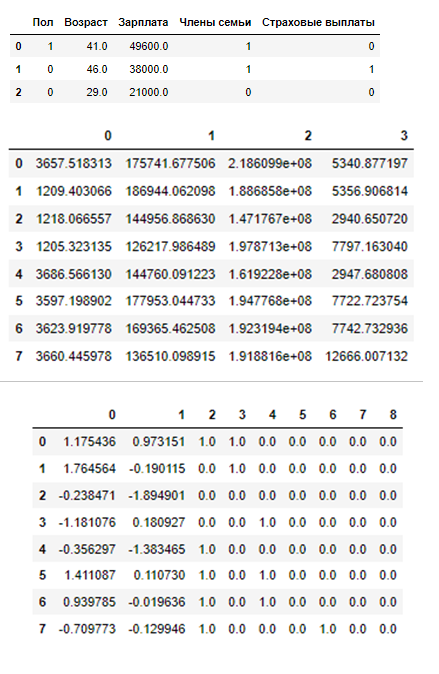